# Starting by going through Gym tutorial.

We're looking to understand the agent system through Gym to later be able to implement custom environments to interact with.

> I'll be actively reading the documentation for python's `gym` while writing this: https://gym.openai.com/envs/MountainCar-v0/
> 
> Also, there is an excellent walk-through on PythonProgramming.net which I looked at and replicated at points: https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])
np.random.seed(2021)

## Rendering an agent taking random action.

In [3]:
# Basic setup
env = gym.make('MountainCar-v0')
env.reset()

# Number of actions available in the space.
print(env.action_space.n)

3


In [4]:
# Starting "observation state."
print(env.reset()) # `[location, velocity]`

[-0.52887982  0.        ]


In [5]:
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

- *There are two observations that the agent is privy to with this environment: the location of the car and the velocity of the car.*

- *There are three actions the agent can take at any point:*
  1. *Move left* 
  2. *Move right*
  3. *Don't move*

## `env.step()` returns:
- `observation` object ("game state")
- reward (float)
- done (bool)
- info (dict)

In [6]:
# Observe the elements returned from env.step().
env = gym.make('MountainCar-v0')

observation = env.reset()

action = env.action_space.sample() # choose action
observation, reward, done, info = env.step(action) # take step
print(f'{observation}\t{reward}\t{done}')
    
env.close()

[-0.41599129 -0.00180594]	-1.0	False


## Underbelly of `env`

In [7]:
env = gym.make('MountainCar-v0')
print(f'Action Space:\n\t{env.action_space}')
print(f'Observation Space:\n\t{env.observation_space}')

Action Space:
	Discrete(3)
Observation Space:
	Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [8]:
print(f'Observation Space Bounds')
print(f'High\t', env.observation_space.high)
print(f'Low\t', env.observation_space.low)

Observation Space Bounds
High	 [0.6  0.07]
Low	 [-1.2  -0.07]


## Controlling the action

In [9]:
env = gym.make('MountainCar-v0')
env.reset()

for _ in range(100):
    action = 2 # always choose to move the car to the right
    observation, reward, done, info = env.step(action)
    env.render()
env.close()

# Training an agent

## Setup

*The steps here can be found on PythonProgramming.net's tutorial: https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/*

*I walk through them to understand them myself and organize them in order to recreate them later.*

In [10]:
# Setup
env = gym.make('MountainCar-v0')
env.reset()

array([-0.45748826,  0.        ])

In [11]:
# Create a q-table.
obs_size = [20, 20] # Arbitrary choice - binning continuous into categorical.

# Create discrete vars from continuous vars.
win_size = (env.observation_space.high - env.observation_space.low) / obs_size
win_size

array([0.09 , 0.007])

In [12]:
# All rewards are -1 unless you reach the goal
q_table = np.random.uniform(
    low=-2, high=0, size=(obs_size + [env.action_space.n])
)
q_table.shape

(20, 20, 3)

In [13]:
# Each column is an action. 
# There are 20 discrete positions and 20 discrete velocities.
print('Actions from [position-0, velocity-0]:\n\t', q_table[0][0])

Actions from [position-0, velocity-0]:
	 [-0.78804344 -0.53326128 -1.72210569]


In [14]:
print('Actions from [position-0, all-velocities]:\n', q_table[0])

Actions from [position-0, all-velocities]:
 [[-0.78804344 -0.53326128 -1.72210569]
 [-1.37465383 -0.00551344 -1.74367525]
 [-1.64201379 -0.49414914 -0.67567897]
 [-0.43137974 -1.80621121 -1.88285743]
 [-0.07520802 -0.76688511 -1.82674008]
 [-0.87745527 -0.76695058 -0.07231395]
 [-0.85139141 -1.2576783  -1.09570951]
 [-1.5962995  -0.86138976 -1.60980805]
 [-0.83259197 -1.04737305 -0.9643712 ]
 [-0.35380273 -0.53554995 -1.86188745]
 [-0.65574213 -0.71303039 -0.34397126]
 [-1.59106121 -0.76502209 -0.76459798]
 [-1.39786276 -0.25651883 -0.82069184]
 [-0.03645981 -1.11553553 -1.74736463]
 [-0.9823382  -1.13642763 -0.16812087]
 [-0.58196872 -0.21868923 -0.82222878]
 [-0.72634015 -1.31558213 -0.35241763]
 [-1.38969846 -1.38491307 -1.59735468]
 [-1.4696701  -0.69815249 -1.69077038]
 [-1.222601   -0.70477171 -0.30340177]]


In [15]:
def get_discrete_state(state):
    """Returns a binned state (tuple)."""
    
    discrete_state = (state - env.observation_space.low) / win_size
    return (round(discrete_state[0]), round(discrete_state[1]))

test_state = get_discrete_state(env.reset())
print('Discrete State:\n\t', test_state)
print('Q-Table Entry:\n\t', q_table[test_state])
print('Max Q-value at State:\n\t', np.argmax(q_table[test_state]))

Discrete State:
	 (8, 10)
Q-Table Entry:
	 [-0.24085283 -0.73670442 -1.91457276]
Max Q-value at State:
	 0


In [16]:
# Set some variables.
learning_rate = 0.1
discount = 0.95 # measure of how we value future reward vs current reward
episodes = 10_000
show_every = 500

# We want the agent to explore the environment to some extent for a while to 
# make sure they are finding all the nooks and crannies.
epsilon = 1
start_decay = 1 # episode number
end_decay = episodes//2 # episode when we stop decaying 
decay_value = epsilon / (end_decay - start_decay)
print(f'''
Epsilon:     {epsilon}
Start Decay: {start_decay}
End Decay:   {end_decay}
Decay Value: {decay_value}
''')


Epsilon:     1
Start Decay: 1
End Decay:   5000
Decay Value: 0.00020004000800160032



In [17]:
def calculate_q_val(
    learning_rate,
    current_q_val,
    reward,
    discount,
    max_future_q):
    """https://en.wikipedia.org/wiki/Q-learning"""
    
    temporal_difference = (reward + discount * max_future_q)
    return (1 - learning_rate) * current_q_val + learning_rate * \
            temporal_difference

In [18]:
# Stat tracking
episode_reward_lst = []
episode_reward_details = {
    'episode': [],
    'average': [],
    'max': [],
    'min': []
}

## Training

In [19]:
# Iterate over number of episodes.
for episode in range(1, episodes+1):
    # Begin tracking rewards picked up by the agent.
    total_reward = 0
    
    # Rendering settings.
    if episode % show_every == 0:
        clear_output(wait=True)
        print(episode)
        render = True
    else:
        clear_output(wait=True)
        print(episode)
        render = False
        
    # Get initial game state (this will be updated).
    discrete_state = get_discrete_state(env.reset())

    # Run through an episode.
    done = False
    while not done:
        # Check if we're exploring or exploiting the environment.
        if np.random.random() > epsilon:
            # Based on the current `discrete state`, what does the q-table say?
            action = np.argmax(q_table[discrete_state])
        else:
            # Be an explorer!
            action = env.action_space.sample()
        
        # Take the action and get the new info.
        observation, reward, done, info = env.step(action)
        
        total_reward += reward
        
        # Set the new state to discrete.
        new_discrete_state = get_discrete_state(observation)
        
        # Are we going to see it?
        if render:
            env.render()

        if not done:
            # Once we look forward to the new_discrete_state, we find the 
            # q-value associated with it. The previous action brought us here,
            # so they are connected concretely.
            max_future_q = np.max(q_table[new_discrete_state])
            
            # Last action's q-value.
            current_q_val = q_table[discrete_state + (action,)]

            # Calculating new q_values.
            new_q = calculate_q_val(learning_rate, current_q_val, 
                                    reward, discount, max_future_q)
            
            # Update the "current" discrete state's q to represent the
            # consequences of the action.
            q_table[discrete_state + (action,)] = new_q
            
        elif observation[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = reward # == 0 for completion.

        discrete_state = new_discrete_state
        
        # Adjust epsilon - the liklihood the agent will explore randomly.
        if end_decay >= episode >= start_decay:
            epsilon -= decay_value
            
    # Track stats.
    episode_reward_lst.append(total_reward)
    if episode % 100 == 0:
        recent_100 = episode_reward_lst[-100:]
        episode_reward_details['episode'].append(episode)
        episode_reward_details['average'].append(sum(recent_100)/100)
        episode_reward_details['max'].append(max(recent_100))
        episode_reward_details['min'].append(min(recent_100))
            
    env.close()

10000


## Plot Metrics

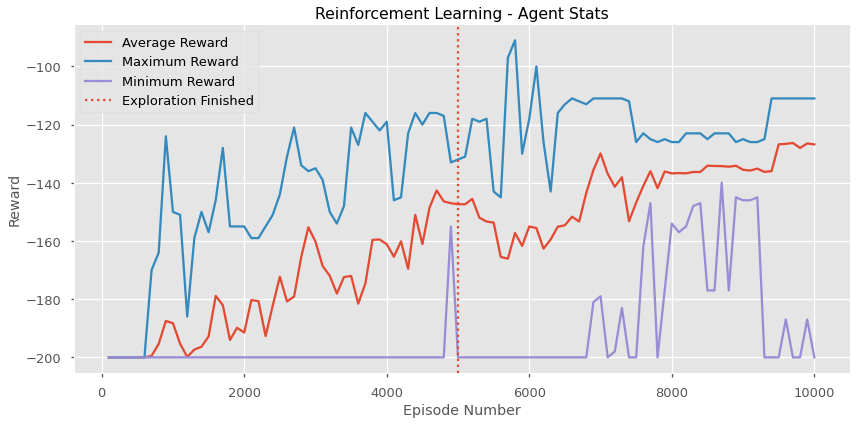

In [20]:
# Plot results.
fig, ax = plt.subplots(figsize=(12, 6))

to_plot = [
    ('average', 'Average Reward'),
    ('max', 'Maximum Reward'),
    ('min', 'Minimum Reward')
]

for y, label in to_plot:
    ax.plot(
        episode_reward_details['episode'], 
        episode_reward_details[y],
        label=label
        )
ax.axvline(x=end_decay, ls='dotted', label='Exploration Finished')
ax.set(
    title='Reinforcement Learning - Agent Stats',
    xlabel='Episode Number',
    ylabel='Reward')
ax.legend()
fig.tight_layout()